In [9]:
import pysam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from Bio import SeqIO
import pandas as pd

In [3]:
!samtools flagstat "aln_nanopore.sam"
print('\n')
!samtools flagstat "aln_pacbio.sam"

32103 + 0 in total (QC-passed reads + QC-failed reads)
1072 + 0 secondary
221 + 0 supplementary
0 + 0 duplicates
29565 + 0 mapped (92.09% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


44635 + 0 in total (QC-passed reads + QC-failed reads)
581 + 0 secondary
2607 + 0 supplementary
0 + 0 duplicates
31829 + 0 mapped (71.31% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [14]:
def aln2cov(samfile, ref_file):
    samfile = pysam.AlignmentFile(samfile, "rb")
    refseq = SeqIO.read(ref_file, "fasta").seq
    coverage = {}
    
    for read in samfile.fetch():
        start_read, end_read = read.reference_start, read.reference_end
        if start_read and end_read: # Check mapped
            for pos in range(start_read, end_read):
                if pos in coverage:
                    coverage[pos] += 1
                else:
                    coverage[pos] = 1
    samfile.close()
    return coverage

def mean_coverage(dict_coverage):
    return np.array(list(dict_coverage.values())).mean()

def count_coverage(dict_coverage, refrence_sequance):
    return round(len(dict_coverage.keys()) / len(refrence_sequance), 15)

def plot_coverage(dict_coverage):
    x, y = list(dict_coverage.keys()), list(dict_coverage.values())
    plt.figure(figsize=(15, 10))
    plt.xlabel('Позиция нуклеотида в геноме')
    plt.ylabel('Количество ридов, которые покрыли нуклеотид')
    plt.axhline(y=mean_coverage(dict_coverage), label='Среднее покрытие', color='r', linestyle='--')
    plt.legend()
    sns.scatterplot(x, y)

def count_indels(samfile):
    samfile = pysam.AlignmentFile(samfile, "r") 
    insertions, deletions, counter = 0, 0, 0
    
    for x in samfile.fetch():
        if x.cigartuples:
            for type_indel, lenght in x.cigartuples:
                if type_indel == 0:
                    counter += lenght
                if type_indel == 1:
                    insertions += lenght
                if type_indel == 2:
                    deletions += lenght
    return (insertions / counter, deletions / counter)
    
def plot_indel(samfile):
    samfile = pysam.AlignmentFile(samfile, "r") 
    lenght_insertion = []
    lenght_deletion = []
    lenght_indel = []
    for x in samfile.fetch():
        if x.cigartuples:
            for type_indel, lenght in x.cigartuples:
                if type_indel == 1:
                    lenght_insertion.append(lenght)
                if type_indel == 2:
                    lenght_deletion.append(lenght)
                if type_indel == 1 or type_indel == 2:
                    lenght_indel.append(lenght)

    tempory_counters = [Counter(array) for array in [lenght_insertion, lenght_deletion]]
    
    fig, ax = plt.subplots(figsize=(15, 10))
    for counter, label in zip(tempory_counters, ['insertion', 'deletion']):
        x = list(counter.keys())
        y = list(counter.values())
        plt.scatter(x, y, label=label, linewidth=2)

    plt.legend(loc=1, prop={'size': 16})
    plt.xlabel('Длина индела')
    plt.ylabel('Количество инделов с такой длиной')
    plt.grid()
    plt.xlim(0, 100)

def plot_kde_replacment(samfile):
    samfile = pysam.AlignmentFile(samfile, "r") 
    quality_indel = []
    for read in samfile.fetch():
        acnt, generator = -1, read.cigartuples
        if generator:
            for ind, cnt in generator:
                if ind == 0:
                    acnt += cnt
                if ind == 1:
                    quality_indel.append(ord(read.qual[acnt]) - 33)
    
    plt.figure(figsize=(15, 10))
    plt.xlabel('Качество нуклеотида')
    plt.ylabel('Частота')
    sns.kdeplot(quality_indel)
def template_lenght(samfile, confidience, scale=False):
    samfile = pysam.AlignmentFile(samfile, "r") 
    templates = []
    for x in samfile.fetch():
        if x.template_length > 0:
            templates.append(x.template_length)
            
    samfile.close()
    
    counter_templates = Counter(templates)
    x = np.array(list(range(len(counter_templates))))
    y = np.array([counter_templates[i] for i in range(len(counter_templates))])
    if scale:
        x, y = x[:1000], y[:1000]
        
    #draw temlates lenght
    plt.figure(figsize=(15, 10))
    plt.xlabel('Расстояние вставки')
    plt.ylabel('Количество с таким расстоянием вставки')
    plt.grid()
    
    # Calculate cond interval
    cnt, min_index_l, min_index_r = 0, 0, 0
    left, right = sum(y) * (1 - confidience) / 2, sum(y) * (1 + confidience) / 2
    for index, elem in enumerate(array[1]):
        cnt += elem
        if cnt > left and min_index_l == 0:
            min_index_l = index
        if cnt > right and min_index_r == 0:
            min_index_r = index
            break
    
    #draw other
    plt.axvline(x[min_index_l], linestyle='--', color='r', label='left confidence interval')
    plt.axvline(x[min_index_r], linestyle='--', color='r', label='right confidence interval')
    plt.legend()
    sns.scatterplot(x, y, color='k')
    return x, y

def matrix_substitutions(samfile, refrence):
    samfile = pysam.AlignmentFile(samfile, "rb")
    replacment = {'A' : [], 'G' : [], 'C' : [], 'T' : [], '_' : []}
    refseq = SeqIO.read(refrence, 'fasta')
    
    for read in samfile.fetch():
        generator, acc = [], 0
        if read.cigartuples and read.seq:
            for ind, count in read.cigartuples:
                generator.append([ind, [acc, acc + count]])
                acc += count
            l_read, l_reference, counter_ind, cnt = 0, read.reference_start, 0, 0
            iterations = 0
            while l_read != len(read.seq):
                if generator[counter_ind][0] == 0:
                    replacment[refseq[l_reference]].append(read.seq[l_read])
                    l_read += 1
                    l_reference += 1
                if generator[counter_ind][0] == 1:
                    replacment['_'].append(read.seq[l_read])
                    l_reference += 1
                    l_read += 1
                if generator[counter_ind][0] == 2:
                    replacment[refseq[l_reference]].append('_')
                    l_read += 1
                if generator[counter_ind][0] == 4:
                    l_read += 1
                    l_reference += 1
                if l_read == generator[counter_ind][1][1]:
                    counter_ind += 1
                if iterations > 150:
                    break
    samfile.close()
    
    return replacment

def matrix_substitutions_2(samfile, refrence):
    samfile = pysam.AlignmentFile(samfile, threads=4)
    refseq = SeqIO.read(refrence, 'fasta')
    matrix = {nucl_1 : {nucl_2 : 0 for nucl_2 in ['A', 'G', 'C', 'T', '']} for nucl_1 in ['A', 'G', 'C', 'T']}
    for columns in samfile.pileup():
        ref_nucl = refseq[columns.reference_pos]
        for nucl in ['A', 'C', 'T', 'G', '']:
            matrix[ref_nucl][nucl] += Counter(columns.get_query_sequences())[nucl]
    return matrix

In [24]:
SAM_FILE_PACBIO = "aln_nanopore.sam"
SAM_FILE_NANOPORE = "aln_pacbio.sam"
BAM_FILE_PACBIO = 'pacbio.bam'
BAM_FILE_NANOPORE = 'nanopore.bam' 
REFERENCE_FILE = "reference.fasta"

refseq = SeqIO.read(REFERENCE_FILE, 'fasta').seq

In [6]:
coverage_1 = aln2cov(SAM_FILE_NANOPORE, REFERENCE_FILE)
coverage_2 = aln2cov(SAM_FILE_PACBIO, REFERENCE_FILE)

### 1. Покрытие генома

NANOPORE:
Среднее покрытие генома: 28.61738475591173
Процент покрытого генома: 99.9999784467662 %

PACBIO:
Среднее покрытие генома: 28.325001638046828
Процент покрытого генома: 99.99993534029859 %


Text(0.5, 1.0, 'Coverage Pacbio')

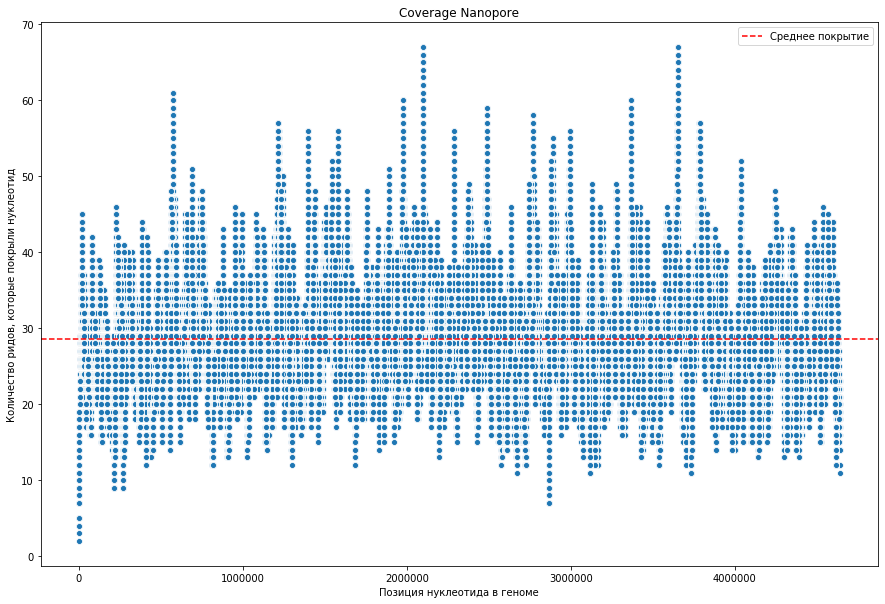

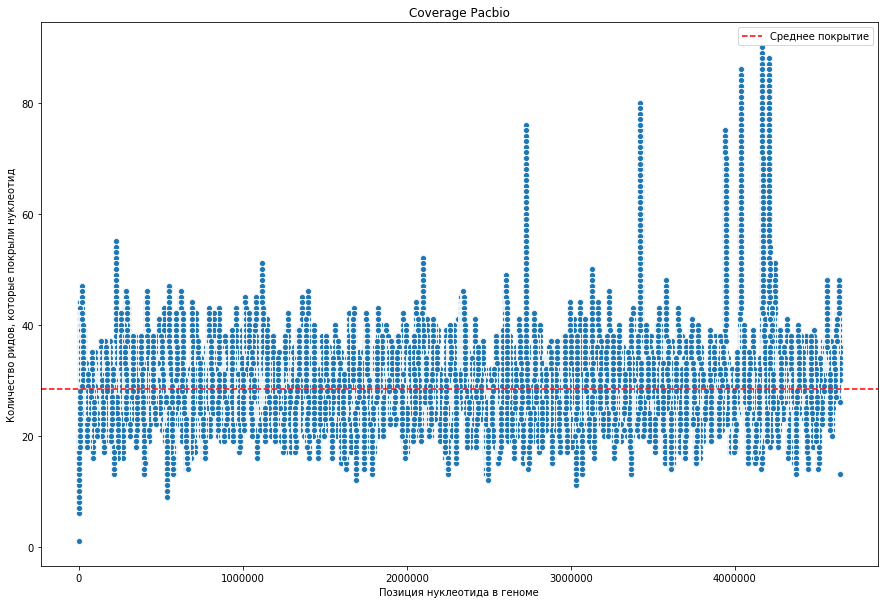

In [41]:
plot_coverage(coverage_1)
print('NANOPORE:')
print('Среднее покрытие генома:', mean_coverage(coverage_1))
print('Процент покрытого генома:', count_coverage(coverage_1, refseq) * 100, '%')
plt.title('Coverage Nanopore')
print()
print('PACBIO:')
plot_coverage(coverage_2)
print('Среднее покрытие генома:', mean_coverage(coverage_2))
print('Процент покрытого генома:', count_coverage(coverage_2, refseq) * 100, '%')
plt.title('Coverage Pacbio')

### 2. Процент ошибок
#### Колонки референсный файл, строки риды

In [26]:
replacment_1 = matrix_substitutions_2(BAM_FILE_NANOPORE, REFERENCE_FILE)
replacment_2 = matrix_substitutions_2(BAM_FILE_PACBIO, REFERENCE_FILE)

In [30]:
print('NANOPORE')
df = pd.DataFrame(replacment_1)
df['sum'] = df.sum(axis=1)
df = df.div(df["sum"], axis=0)
df.drop('sum', axis=1)

NANOPORE


,A,G,C,T
A,0.996374,0.002227,0.000801,0.000599
G,0.003336,0.995395,0.000562,0.000707
C,0.000694,0.000456,0.996649,0.002200
T,0.000671,0.000713,0.001934,0.996682
,0.257554,0.240764,0.244199,0.257482


In [31]:
print('PACBIO')
df = pd.DataFrame(replacment_2)
df['sum'] = df.sum(axis=1)
df = df.div(df["sum"], axis=0)
df.drop('sum', axis=1)

PACBIO


,A,G,C,T
A,0.981480,0.005702,0.007086,0.005733
G,0.004567,0.986015,0.004796,0.004622
C,0.006001,0.007949,0.981447,0.004603
T,0.005294,0.005935,0.005063,0.983708
,0.189750,0.319372,0.272255,0.218622


### 3. Распределение типов замен

In [8]:
insertions, deletions = count_indels(SAM_FILE_NANOPORE)
print(f'NANOPORE, insertion: {insertions * 100} %, deletion: {deletions * 100} %')
insertions, deletions = count_indels(SAM_FILE_PACBIO)
print(f'PACBIO, insertion: {insertions * 100} %, deletion: {deletions * 100} %')

NANOPORE, insertion: 6.00700491509296 %, deletion: 3.104772230008946 %
PACBIO, insertion: 1.2900696271763772 %, deletion: 5.1114840016934595 %


### 4. Распределение типов инделов

Text(0.5, 1.0, 'Pacbio')

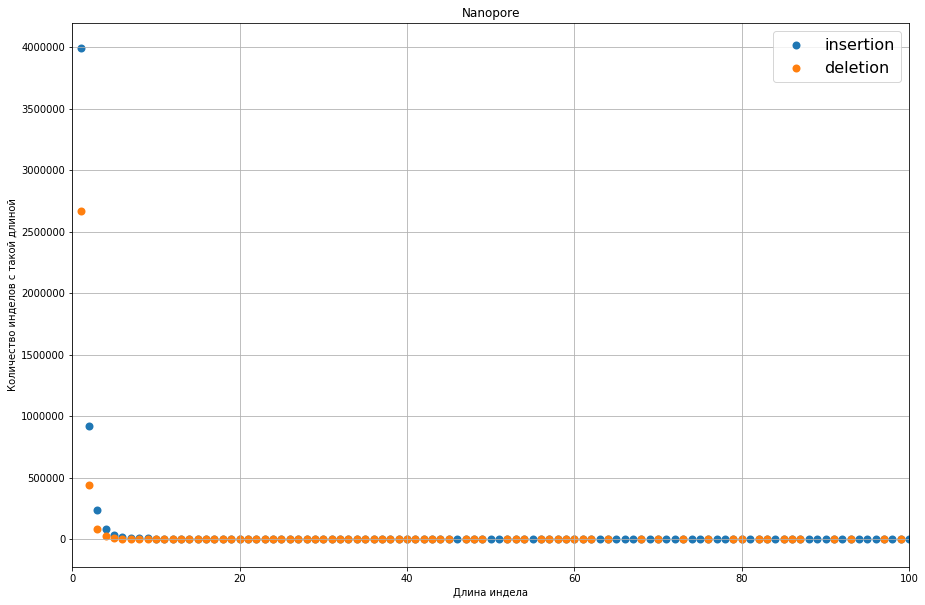

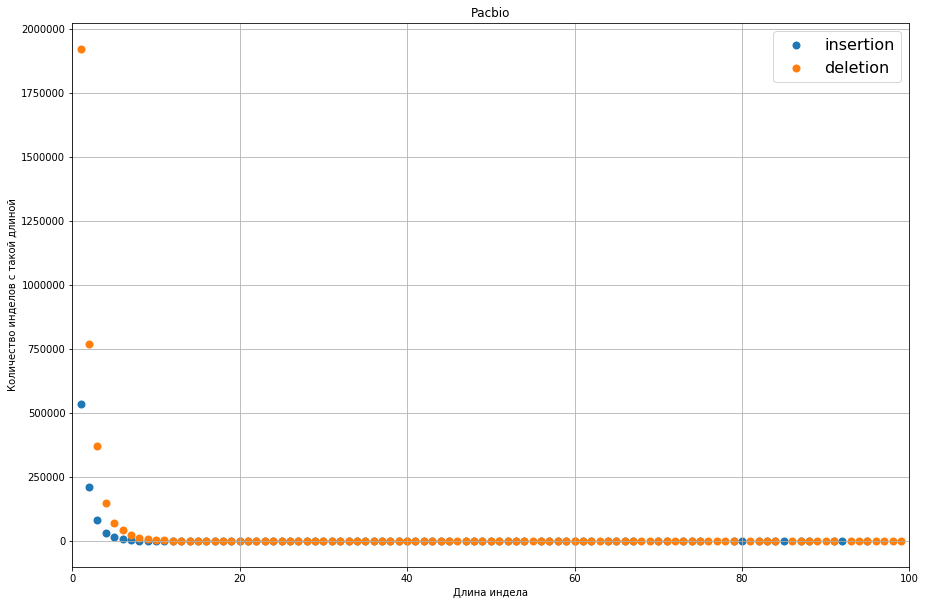

In [13]:
plot_indel(SAM_FILE_NANOPORE)
plt.title('Nanopore')
plot_indel(SAM_FILE_PACBIO)
plt.title('Pacbio')